In [1]:
# Import dependencies
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random
random.seed(202403)

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix

from typing import Union
from keras import layers, optimizers, Model, callbacks
from keras.applications import DenseNet121, EfficientNetV2B0, MobileNetV3Small
from keras.preprocessing.image import ImageDataGenerator, DataFrameIterator

In [2]:
# Define constants
DATA_DIR = 'data'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TEST_DIR = os.path.join(DATA_DIR, 'test')
CLASSES = ['galaxy', 'star']
TRAIN_SPLIT = 0.8

# Create train and test directories
os.makedirs(TRAIN_DIR, exist_ok=True)
os.makedirs(TEST_DIR, exist_ok=True)


# Define function to split data and move files
def split_and_move_data(source_dir: str, train_dest_dir: str, test_dest_dir: str, split_ratio: float) -> None:
    """
    Split data into training and testing sets and move files accordingly.

    Args:
        source_dir (str): Directory containing the source data.
        train_dest_dir (str): Destination directory for training data.
        test_dest_dir (str): Destination directory for testing data.
        split_ratio (float): Ratio of data to be allocated for training.

    Returns:
        None
    """
    files = os.listdir(source_dir)
    random.shuffle(files)
    train_size = int(split_ratio * len(files))
    train_files = files[:train_size]
    test_files = files[train_size:]

    for filename in train_files:
        shutil.copy(os.path.join(source_dir, filename), os.path.join(train_dest_dir, filename))
    for filename in test_files:
        shutil.copy(os.path.join(source_dir, filename), os.path.join(test_dest_dir, filename))

        
# Split and move data for each class
for label in CLASSES:
    source_dir = os.path.join(DATA_DIR, label)
    train_label_dir = os.path.join(TRAIN_DIR, label)
    test_label_dir = os.path.join(TEST_DIR, label)
    os.makedirs(train_label_dir, exist_ok=True)
    os.makedirs(test_label_dir, exist_ok=True)
    split_and_move_data(source_dir, train_label_dir, test_label_dir, TRAIN_SPLIT)

In [3]:
TRAIN_GALAXY = os.path.join(TRAIN_DIR, 'galaxy')
TEST_GALAXY = os.path.join(TEST_DIR, 'galaxy')

TRAIN_STAR = os.path.join(TRAIN_DIR, 'star')
TEST_STAR = os.path.join(TEST_DIR, 'star')


def count_files(directory: str) -> int:
    """
    Counts the number of files in the given directory.

    Args:
        directory (str): The directory path.

    Returns:
        int: Number of files in the directory.
    """
    return sum(len(files) for _, _, files in os.walk(directory))


def print_file_counts(directory_list: list) -> None:
    """
    Prints the number of files in each directory.

    Args:
        directory_list (list): List of directory paths.
    """
    for directory in directory_list:
        file_count = count_files(directory)
        print(f"Number of files in {directory}: {file_count}")

# Print number of files in each directory
directories = [TRAIN_GALAXY, TEST_GALAXY, TRAIN_STAR, TEST_STAR]
print_file_counts(directories)

Number of files in data/train/galaxy: 753
Number of files in data/test/galaxy: 189
Number of files in data/train/star: 2435
Number of files in data/test/star: 609


In [4]:
def generate_datagen_object(train_directory: str, test_directory: str, batch_size: int) -> tuple:
    """
    Generate data iterators using ImageDataGenerator.

    Parameters:
    train_directory (str): Path to the directory containing training images.
    test_directory (str): Path to the directory containing testing images.

    Returns:
    tuple: A tuple containing train_iterator and test_iterator.
    """
    # Define data generators for train and test
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=(90),
        horizontal_flip=True,
        vertical_flip=True
    )

    test_datagen = ImageDataGenerator(rescale=1./255)

    # Generate train and test iterators
    train_iterator = train_datagen.flow_from_directory(
        train_directory,
        target_size=(64, 64),
        class_mode='binary',
        batch_size=batch_size,
        shuffle=True,
    )

    test_iterator = test_datagen.flow_from_directory(
        test_directory,
        target_size=(64, 64),
        class_mode='binary',
        batch_size=batch_size,
        shuffle=False
    )

    # Calculate class weights to handle class imbalance
    class_weights = compute_class_weight(class_weight='balanced', 
                                         classes=np.unique(train_iterator.classes), 
                                         y=train_iterator.classes)
    
    class_weights = dict(zip(np.unique(train_iterator.classes), class_weights))

    return train_iterator, test_iterator, class_weights


# Get the train and test iterator object along with class weights
train, test, class_weights = generate_datagen_object(TRAIN_DIR, TEST_DIR, batch_size=32)

# Check image shapes
img, label = train[0]
print(f'The image shape is {img.shape}.')

Found 3188 images belonging to 2 classes.
Found 798 images belonging to 2 classes.
The image shape is (32, 64, 64, 3).


In [5]:
# Define a function for creating model with transfer learning
def create_model(model_name: str, include_top: bool=False, weight: str='imagenet', 
                 num_classes: int=2, trainable: bool=False, learning_rate: float=1e-3) -> Model:
    """
    Creates a CNN model based on the specified architecture.

    Args:
        model_name (str): Name of the model architecture.
        include_top (bool): Whether to include the fully connected layer at the top of the network.
        weight (str): Specifies the weight initialization to be used. Default is 'imagenet'.
        num_classes (int): Number of output classes.
        trainable (bool): Whether the model's layers are trainable.
        learning_rate (float): Learning rate for model compilation.

    Returns:
        TensorFlow Model: Compiled CNN model.
    """
    # Define input layer
    inputs = layers.Input(shape=(64, 64, 3))
    
    # Select model architecture based on model_name
    if model_name == 'DenseNet121':
        base_model = DenseNet121(include_top=include_top, input_tensor=inputs, weights=weight, classes=num_classes)
    elif model_name == 'EfficientNetV2B0':
        base_model = EfficientNetV2B0(include_top=include_top, input_tensor=inputs, weights=weight, classes=num_classes)
    elif model_name == 'MobileNetV3Small':
        base_model = MobileNetV3Small(include_top=include_top, input_tensor=inputs, weights=weight, classes=num_classes)
    else:
        raise ValueError("Invalid model type.")
    
    # Set model's trainable property
    base_model.trainable = trainable
    
    # If include_top is False, add custom top layers
    if not include_top:
        x = layers.GlobalAveragePooling2D(name="avg_pool")(base_model.output)
        x = layers.BatchNormalization()(x)
        outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)
        model = Model(inputs, outputs, name=model_name)
    else:
        model = base_model
    
    # Compile the model with custom Accuracy metric
    optimizer = optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])

    return model


# Create the baseline models
dense_model = create_model('DenseNet121')
efficient_model = create_model('EfficientNetV2B0')
mobile_model = create_model('MobileNetV3Small')

4334752/4334752 [==============================] - 0s 0us/step


In [6]:
def train_and_plot(model: Model, 
                   train_data: DataFrameIterator,
                   validation_data: DataFrameIterator, 
                   epochs: int = 20,
                   checkpoint_path: str = 'best_model.h5') -> callbacks.History:
    """
    Train the model and plot the loss curve and Accuracy score curve.
    Save the model with the best validation accuracy.

    Args:
        model (tf.keras.Model): The model to be trained.
        train_data (tf.data.Dataset): Dataset containing training data and labels.
        validation_data (tf.data.Dataset): Dataset containing validation data and labels.
        epochs (int): Number of epochs for training.
        checkpoint_path (str): Path to save the model checkpoint.

    Returns:
        tf.keras.callbacks.History: A History object from model training containing loss and Accuracy score values.
    """
    # Define checkpoint callback to save the model with the best validation accuracy
    checkpoint_callback = callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     monitor='val_accuracy',
                                                     save_best_only=True,
                                                     verbose=1)

    # Train the model with checkpoint callback
    history = model.fit(train_data,
                        epochs=epochs,
                        validation_data=validation_data,
                        callbacks=[checkpoint_callback],
                        verbose=1)

    sns.set_theme()
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot loss curve
    axes[0].plot(history.history['loss'], label='Training Loss')
    axes[0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Loss Curve')
    axes[0].legend()

    # Plot Accuracy score curve
    axes[1].plot(history.history['accuracy'], label='Training Accuracy Score')
    axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy Score')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy Score')
    axes[1].set_title('Accuracy Score Curve')
    axes[1].legend()

    plt.tight_layout()
    plt.show()
    
    return history

Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 0.5151 - accuracy: 0.7594
Epoch 1: val_accuracy improved from -inf to 0.76190, saving model to model/DenseNet121.h5
100/100 [==============================] - 16s 93ms/step - loss: 0.5151 - accuracy: 0.7594 - val_loss: 0.6562 - val_accuracy: 0.7619
Epoch 2/20
100/100 [==============================] - ETA: 0s - loss: 0.4331 - accuracy: 0.7967
Epoch 2: val_accuracy improved from 0.76190 to 0.76316, saving model to model/DenseNet121.h5
100/100 [==============================] - 6s 56ms/step - loss: 0.4331 - accuracy: 0.7967 - val_loss: 0.5678 - val_accuracy: 0.7632
Epoch 3/20
100/100 [==============================] - ETA: 0s - loss: 0.4116 - accuracy: 0.8105
Epoch 3: val_accuracy improved from 0.76316 to 0.76942, saving model to model/DenseNet121.h5
100/100 [==============================] - 6s 55ms/step - loss: 0.4116 - accuracy: 0.8105 - val_loss: 0.5128 - val_accuracy: 0.7694
Epoch 4/20
 99/100 [===================

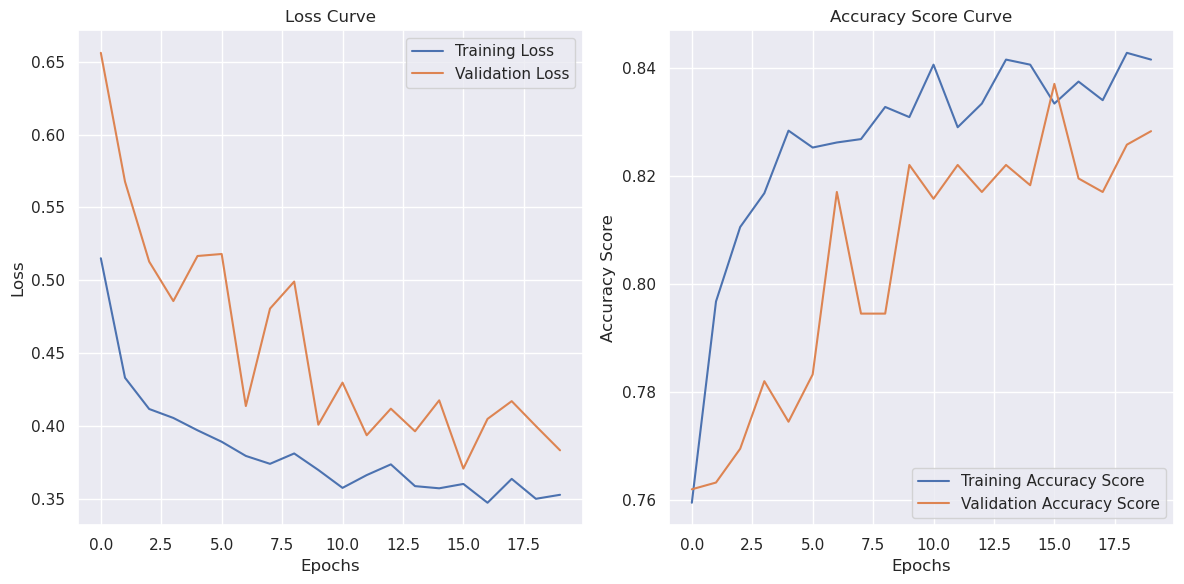

In [7]:
# Train DenseNet121
dense_history = train_and_plot(dense_model, train, test, checkpoint_path='model/DenseNet121.h5')

Epoch 1/20


2024-03-05 08:30:04.870571: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNetV2B0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


100/100 [==============================] - ETA: 0s - loss: 0.5869 - accuracy: 0.7271
Epoch 1: val_accuracy improved from -inf to 0.76316, saving model to model/EfficientNetV2B0.h5
100/100 [==============================] - 14s 76ms/step - loss: 0.5869 - accuracy: 0.7271 - val_loss: 0.5772 - val_accuracy: 0.7632
Epoch 2/20
 99/100 [============================>.] - ETA: 0s - loss: 0.5719 - accuracy: 0.7519
Epoch 2: val_accuracy did not improve from 0.76316
100/100 [==============================] - 5s 48ms/step - loss: 0.5729 - accuracy: 0.7519 - val_loss: 0.5455 - val_accuracy: 0.7632
Epoch 3/20
100/100 [==============================] - ETA: 0s - loss: 0.5628 - accuracy: 0.7550
Epoch 3: val_accuracy did not improve from 0.76316
100/100 [==============================] - 5s 48ms/step - loss: 0.5628 - accuracy: 0.7550 - val_loss: 0.5440 - val_accuracy: 0.7632
Epoch 4/20
 99/100 [============================>.] - ETA: 0s - loss: 0.5611 - accuracy: 0.7573
Epoch 4: val_accuracy did not imp

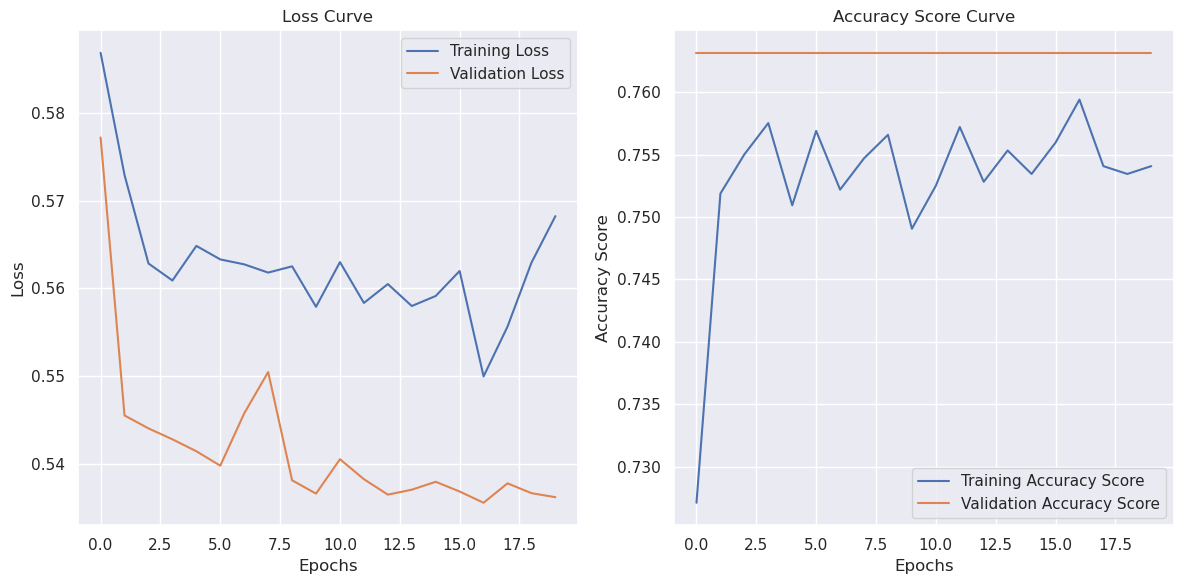

In [8]:
# Train EfficientNetV2B0
efficient_history = train_and_plot(efficient_model, train, test, checkpoint_path='model/EfficientNetV2B0.h5')

Epoch 1/20
 99/100 [============================>.] - ETA: 0s - loss: 0.4982 - accuracy: 0.7630
Epoch 1: val_accuracy improved from -inf to 0.76316, saving model to model/MobileNetV3Small.h5
100/100 [==============================] - 10s 67ms/step - loss: 0.4977 - accuracy: 0.7632 - val_loss: 0.6545 - val_accuracy: 0.7632
Epoch 2/20
 99/100 [============================>.] - ETA: 0s - loss: 0.4309 - accuracy: 0.7839
Epoch 2: val_accuracy did not improve from 0.76316
100/100 [==============================] - 5s 47ms/step - loss: 0.4321 - accuracy: 0.7832 - val_loss: 0.5869 - val_accuracy: 0.7632
Epoch 3/20
100/100 [==============================] - ETA: 0s - loss: 0.4305 - accuracy: 0.7867
Epoch 3: val_accuracy did not improve from 0.76316
100/100 [==============================] - 5s 47ms/step - loss: 0.4305 - accuracy: 0.7867 - val_loss: 0.5294 - val_accuracy: 0.7632
Epoch 4/20
 99/100 [============================>.] - ETA: 0s - loss: 0.4230 - accuracy: 0.7975
Epoch 4: val_accuracy 

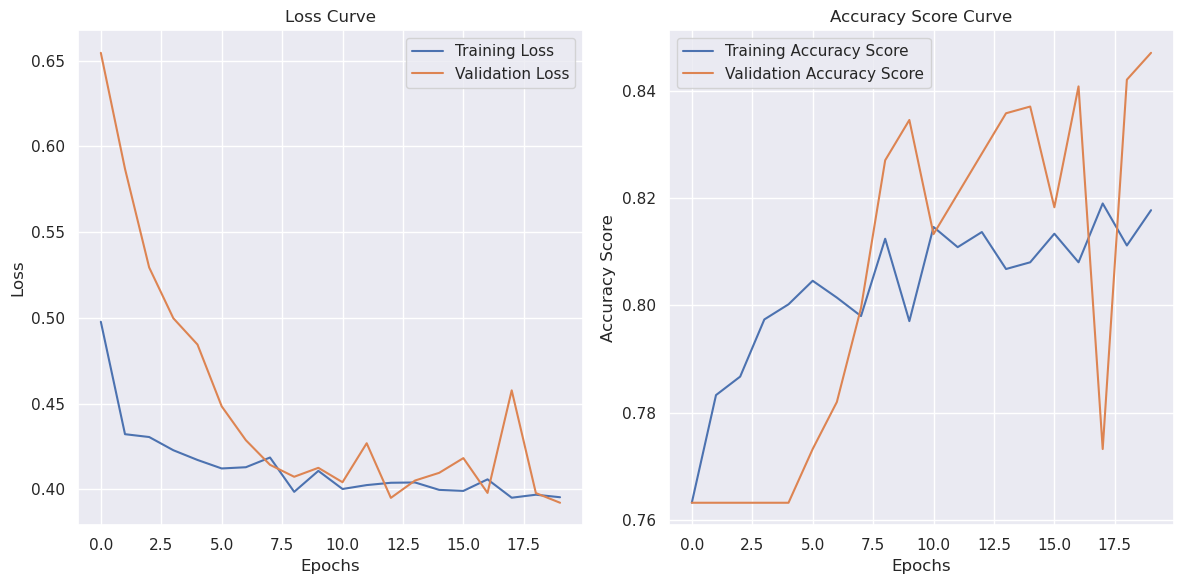

In [9]:
# Train MobileNetV3Small
mobile_history = train_and_plot(mobile_model, train, test, checkpoint_path='model/MobileNetV3Small.h5')

In [10]:
# Define function for ensemble learning
def make_ensemble_prediction(model_list: list, test_data: DataFrameIterator) -> np.array:
    """
    Make predictions using ensemble learning.

    Args:
        model_list (list): List of trained models for ensemble prediction.
        test_data (DataFrameIterator): Iterator containing test data.

    Returns:
        np.array: Ensemble prediction array.
    """
    # Make predictions using each model in the ensemble
    prediction_list = [model.predict(test_data) for model in model_list]
    
    # Calculate average prediction
    average_prediction = np.mean(prediction_list, axis=0)
    
    return average_prediction

In [11]:
def plot_roc_curve(model: Union[Model, None], test_data: DataFrameIterator, y_pred_prob: Union[np.array, None] = None):
    """
    Plot ROC curve for the given model and test data.

    Args:
        model (Model): The trained model.
        test_data (DataFrameIterator): Iterator containing test data.
        y_pred_prob (Union[np.array, None]): Predicted probabilities. Default is None.

    Returns:
        None
    """
    if y_pred_prob is None:
        y_pred_prob = model.predict(test_data)
        
    fpr, tpr, thresholds = roc_curve(test_data.classes, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    
    sns.set_theme()
    plt.plot(fpr, tpr, label='ROC curve (AUC = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()


def generate_classification_report(model: Union[Model, None], test_data: DataFrameIterator, 
                                   y_pred_prob: Union[np.array, None] = None):
    """
    Generate classification report for the given model and test data.

    Args:
        model (Model): The trained model.
        test_data (DataFrameIterator): Iterator containing test data.
        y_pred_prob (Union[np.array, None]): Predicted probabilities. Default is None.

    Returns:
        None
    """
    if y_pred_prob is None:
        y_pred_prob = model.predict(test_data)

    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = test_data.classes

    report = classification_report(y_true, y_pred, target_names=test_data.class_indices)
    print("Classification Report:\n", report)


def plot_confusion_matrix(model: Union[Model, None], test_data: DataFrameIterator, class_labels: list= ['Galaxy', 'Star'], 
                          normalize: bool = True, y_pred_prob: Union[np.array, None] = None):
    """
    Plot confusion matrix for the given model and test data.

    Args:
        model (Model): The trained model.
        test_data (DataFrameIterator): Iterator containing test data.
        class_labels (list): List of class labels.
        normalize (bool): Whether to normalize the confusion matrix. Default is True.

    Returns:
        None
    """
    # Get true labels
    y_true = test_data.classes

    if y_pred_prob is None:
        y_pred_prob = model.predict(test_data)
        
    y_pred = np.argmax(y_pred_prob, axis=1)
        
    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred, normalize='true' if normalize else None)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap="Blues", square=True, fmt='.2f' if normalize else 'd',
                xticklabels=class_labels,
                yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

25/25 [==============================] - 2s 18ms/step


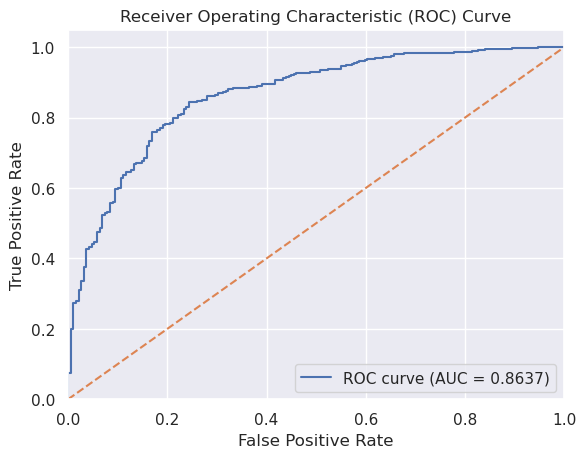

Classification Report:
               precision    recall  f1-score   support

      galaxy       0.72      0.45      0.55       189
        star       0.85      0.95      0.89       609

    accuracy                           0.83       798
   macro avg       0.78      0.70      0.72       798
weighted avg       0.82      0.83      0.81       798



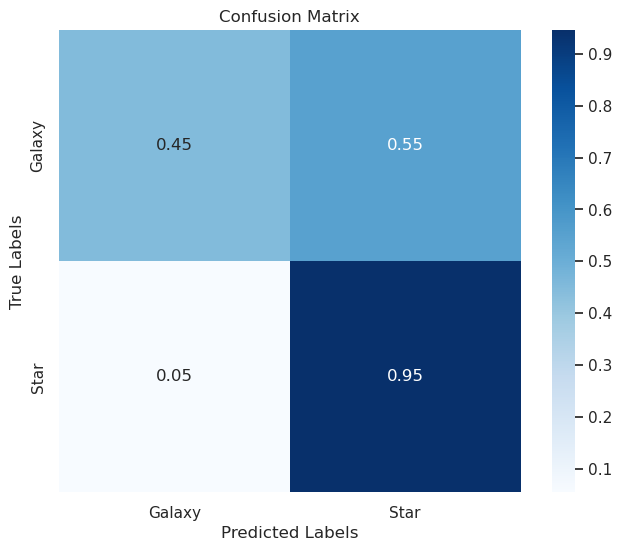

In [12]:
# Evaluate DenseNet
y_pred_prob = dense_model.predict(test)

plot_roc_curve(dense_model, test, y_pred_prob=y_pred_prob)
generate_classification_report(dense_model, test, y_pred_prob=y_pred_prob)
plot_confusion_matrix(dense_model, test, y_pred_prob=y_pred_prob)

25/25 [==============================] - 2s 14ms/step


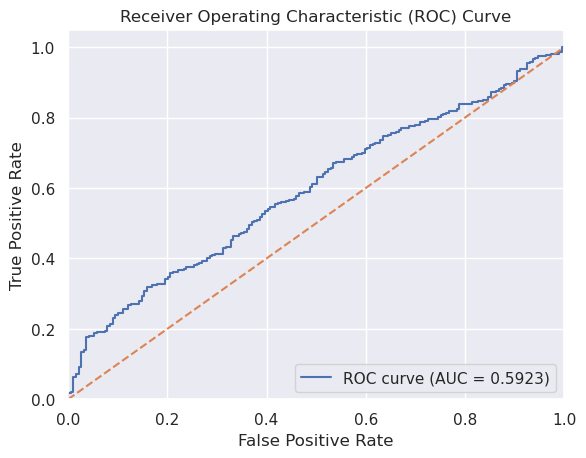

/opt/conda/envs/sagemaker-distribution/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/sagemaker-distribution/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/sagemaker-distribution/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Classification Report:
               precision    recall  f1-score   support

      galaxy       0.00      0.00      0.00       189
        star       0.76      1.00      0.87       609

    accuracy                           0.76       798
   macro avg       0.38      0.50      0.43       798
weighted avg       0.58      0.76      0.66       798



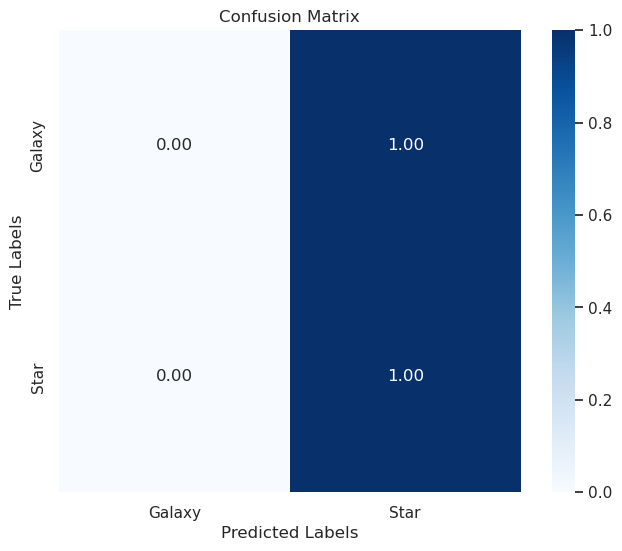

In [13]:
# Evaluate EfficientNetV2B0
y_pred_prob = efficient_model.predict(test)

plot_roc_curve(efficient_model, test, y_pred_prob=y_pred_prob)
generate_classification_report(efficient_model, test, y_pred_prob=y_pred_prob)
plot_confusion_matrix(efficient_model, test, y_pred_prob=y_pred_prob)

25/25 [==============================] - 1s 12ms/step


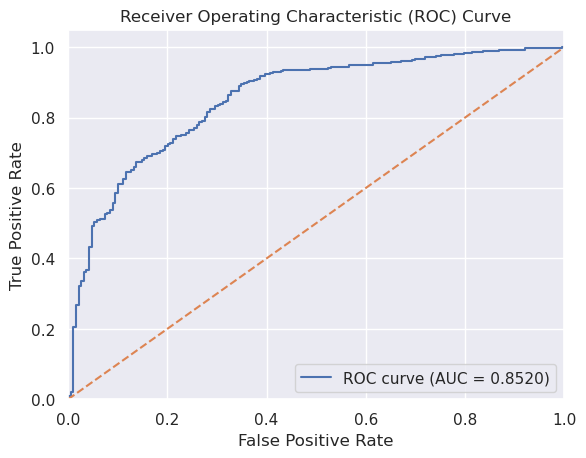

Classification Report:
               precision    recall  f1-score   support

      galaxy       0.72      0.57      0.64       189
        star       0.88      0.93      0.90       609

    accuracy                           0.85       798
   macro avg       0.80      0.75      0.77       798
weighted avg       0.84      0.85      0.84       798



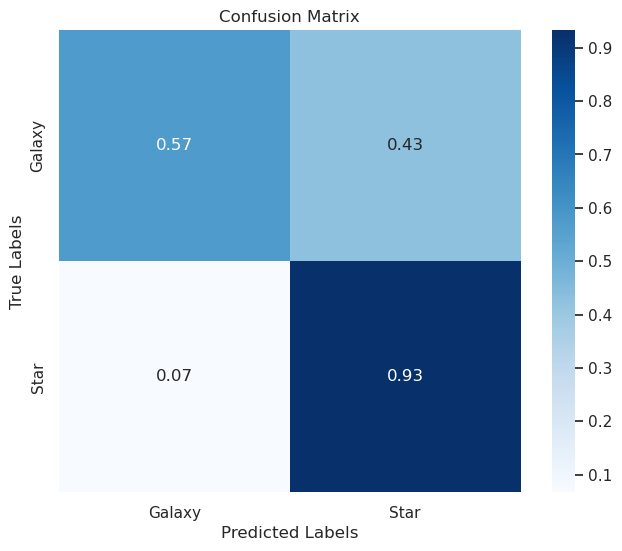

In [14]:
# Evaluate MobileNetV3Small
y_pred_prob = mobile_model.predict(test)

plot_roc_curve(mobile_model, test, y_pred_prob=y_pred_prob)
generate_classification_report(mobile_model, test, y_pred_prob=y_pred_prob)
plot_confusion_matrix(mobile_model, test, y_pred_prob=y_pred_prob)

25/25 [==============================] - 0s 12ms/step


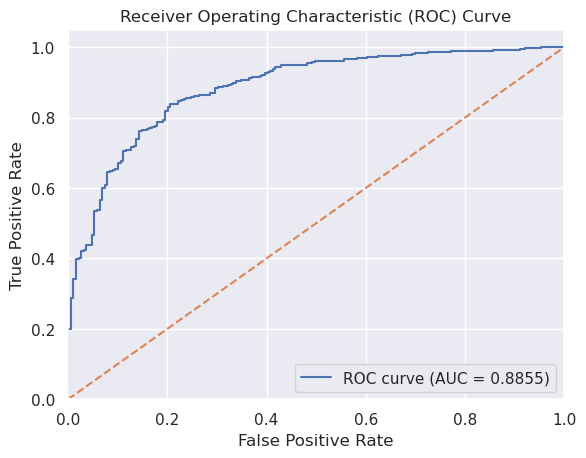

Classification Report:
               precision    recall  f1-score   support

      galaxy       0.83      0.33      0.47       189
        star       0.82      0.98      0.89       609

    accuracy                           0.82       798
   macro avg       0.83      0.65      0.68       798
weighted avg       0.82      0.82      0.79       798



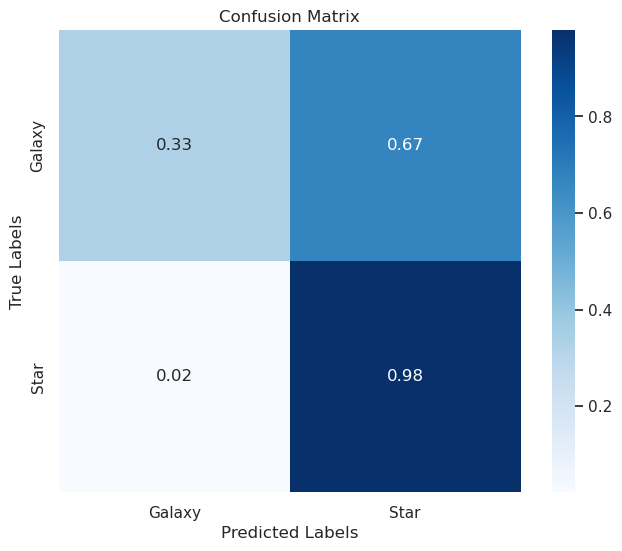

In [15]:
# Evaluate Ensemble Model
model_list = [dense_model, efficient_model, mobile_model]
y_pred_prob = make_ensemble_prediction(model_list, test)

plot_roc_curve(None, test, y_pred_prob=y_pred_prob)
generate_classification_report(None, test, y_pred_prob=y_pred_prob)
plot_confusion_matrix(None, test, y_pred_prob=y_pred_prob)

In [16]:
# Save all models
dense_model.save('model/DenseNet121.h5')
efficient_model.save('model/EfficientNetB0.h5')
mobile_model.save('model/MobileNetV2.h5')